# 10-03 - node2vec

*June 26 2024*  

In [6]:
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch import autograd
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from torch_geometric.data import Data
from torch_geometric.utils import sort_edge_index

from sklearn.decomposition import TruncatedSVD

plt.style.use('default')
sns.set_style("whitegrid")

import pathpyG as pp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pp.config['torch']['device'] = device
print('Running on', pp.config['torch']['device'])

Running on cuda


In [7]:
edges = [
    ('a', 'b'),
    ('b', 'c'),
    ('a', 'c'),
    ('b', 'd'),
    ('d', 'f'),
    ('d', 'g'),
    ('d', 'e'),
    ('e', 'f'),
    ('f', 'g')
]

g = pp.Graph.from_edge_list(edges)
g = g.to_undirected()

In [8]:
list(g.edges)

[(np.str_('a'), np.str_('c')),
 (np.str_('a'), np.str_('b')),
 (np.str_('b'), np.str_('d')),
 (np.str_('b'), np.str_('c')),
 (np.str_('b'), np.str_('a')),
 (np.str_('c'), np.str_('b')),
 (np.str_('c'), np.str_('a')),
 (np.str_('d'), np.str_('f')),
 (np.str_('d'), np.str_('e')),
 (np.str_('d'), np.str_('g')),
 (np.str_('d'), np.str_('b')),
 (np.str_('e'), np.str_('f')),
 (np.str_('e'), np.str_('d')),
 (np.str_('f'), np.str_('e')),
 (np.str_('f'), np.str_('g')),
 (np.str_('f'), np.str_('d')),
 (np.str_('g'), np.str_('d')),
 (np.str_('g'), np.str_('f'))]

In [9]:
def second_order_network(g):
    edge_index = sort_edge_index(g.data.edge_index)
    edge_index_2 = pp.MultiOrderModel.lift_order_edge_index(edge_index, g.data.num_nodes)
    node_sequence_2 = torch.arange(g.data.num_nodes).to(device)[edge_index].T
    data2 = Data(
        edge_index = edge_index_2,
        node_sequence = node_sequence_2,
        num_nodes = g.M
    )
    g2 = pp.Graph(
        data=data2,
        mapping=pp.IndexMap([tuple(g.mapping.to_ids(v.cpu())) for v in node_sequence_2])
    )
    return g2

In [10]:
g2 = second_order_network(g)

In [11]:
list(g2.nodes)

[(np.str_('a'), np.str_('b')),
 (np.str_('a'), np.str_('c')),
 (np.str_('b'), np.str_('a')),
 (np.str_('b'), np.str_('c')),
 (np.str_('b'), np.str_('d')),
 (np.str_('c'), np.str_('a')),
 (np.str_('c'), np.str_('b')),
 (np.str_('d'), np.str_('b')),
 (np.str_('d'), np.str_('e')),
 (np.str_('d'), np.str_('f')),
 (np.str_('d'), np.str_('g')),
 (np.str_('e'), np.str_('d')),
 (np.str_('e'), np.str_('f')),
 (np.str_('f'), np.str_('d')),
 (np.str_('f'), np.str_('e')),
 (np.str_('f'), np.str_('g')),
 (np.str_('g'), np.str_('d')),
 (np.str_('g'), np.str_('f'))]

In [12]:
g2.mapping.to_id(0)

(np.str_('a'), np.str_('b'))

In [13]:
pp.plot(g2, node_label=list(g2.nodes))

In [14]:
def create_search_bias(g2, g, p, q):
    weights = []
    for e in list(g2.edges):
        t = e[0]
        x = e[1]
        if (x[0] == t[1]) and (x[1] == t[0]):
            weights.append(1/p)
        elif (t[0], x[1]) in list(g.edges):
            weights.append(1)
        else:
            weights.append(1/q)
    g2.data.edge_weight = torch.tensor(weights, dtype=torch.float).to(device)
    edge_idx_mapping = {
        e: i for i, e in enumerate(g2.edges)
    }
    return g2, edge_idx_mapping

In [15]:
g2, edge_idx_mapping = create_search_bias(g2, g, p=10, q=0.05)

In [16]:
pp.plot(g, node_label=list(g.nodes))

In [17]:
# example of an "exploitation" step
print(g2.data.edge_weight[edge_idx_mapping[(("a", "b"), ("b", "c"))]].item())

1.0


In [18]:
# exploration step
print(g2.data.edge_weight[edge_idx_mapping[(("a", "b"), ("b", "d"))]].item())

20.0


In [19]:
# backtracking
print(g2.data.edge_weight[edge_idx_mapping[(("a", "b"), ("b", "a"))]].item())

0.10000000149011612


In [20]:
rw = pp.processes.HigherOrderRandomWalk(g2, g, weight=False)

In [21]:
data = rw.run_experiment(steps=10, runs=100)
walk_data = rw.get_paths(data)
walks = []
for walk in walk_data.paths:
    walks.append(g.mapping.to_ids(walk.node_sequence.squeeze().tolist()))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1404.31it/s]


In [22]:
walk_data.paths[0].node_sequence

tensor([[4],
        [3],
        [5],
        [6],
        [3],
        [5],
        [6],
        [3],
        [5],
        [3],
        [6],
        [5]])

In [23]:
example_walk = pp.Graph(walk_data.paths[0])
pp.plot(example_walk, node_label=list(g.mapping.to_ids(example_walk.data.node_sequence.squeeze())))

In [27]:
def build_vocabulary(tokens):
    vocab = []
    for sentence in tokens:
        for word in sentence:
            if word not in vocab:
                vocab.append(word)
    return vocab

def build_word_context_pairs(tokens, window_size):
    pairs = []
    for sentence in tokens:
        for center in range(len(sentence)):
            for i in range(-window_size, window_size+1):
                context_word = center + i
                if context_word < 0 or context_word >= len(sentence) or center == context_word:
                    continue
                pairs.append((sentence[center], sentence[context_word]))
    return pairs

def get_ohe(word, vocab):
    word_idx = vocab.index(word)
    x = torch.zeros(1,len(vocab)).to(device).float()
    x[:,word_idx] = 1.0
    return x

class SkipGram(torch.nn.Module):
    
    # SkipGram model = predict context probabilities based on center word
    # input = one-hot-encoding of center word 
    # outputs y_i = conditional probabilities of context words $j$ given center word
    def __init__(self, embedding_dim, vocab_size):
        super(SkipGram, self).__init__()

        # The first layer has |V| * d learnable weights
        self.embeddings = torch.nn.Linear(vocab_size, embedding_dim)

        # The second layer has d * |V| learnable weights
        self.linear = torch.nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, x):

        emb_x = self.embeddings(x)
        y = self.linear(emb_x)
        return F.softmax(y, dim=1)


def get_embedding(node, model, vocab):
    return model.embeddings.weight.data[:,vocab.index(node)]

def context_probs(word, vocab, model):
    return { x:p for x,p in zip(vocab, model.forward(get_ohe(word, vocab))[0].detach())}

cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

In [28]:
vocab = build_vocabulary(walks)
pairs = build_word_context_pairs(walks, window_size=2)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:52<00:00,  2.65s/it]


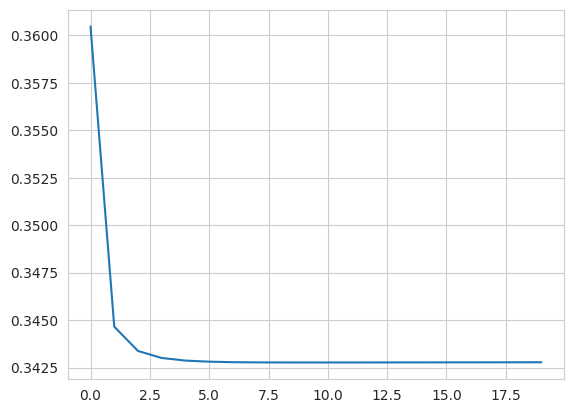

In [29]:
model = SkipGram(embedding_dim=5, vocab_size=len(vocab)).to(device)

loss_function = torch.nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
epochs = 20
losses = []
for i in tqdm(range(epochs)):
    l = 0
    for center, context in pairs:
        model.zero_grad()
        prob = model.forward(get_ohe(center, vocab))
        loss = loss_function(prob, get_ohe(context, vocab).float())
        loss.backward()
        optimizer.step()        
        l += loss.data.to('cpu')

    losses.append(l/len(pairs))
plt.plot(range(epochs), losses)

In [30]:
get_embedding('a', model, vocab)

tensor([ 1.6699,  0.1231, -0.5646,  0.0369, -0.5248], device='cuda:0')

In [31]:
context_probs('a', vocab, model)

{'e': tensor(0.0095, device='cuda:0'),
 'd': tensor(0.1365, device='cuda:0'),
 'f': tensor(0.0093, device='cuda:0'),
 'g': tensor(0.0052, device='cuda:0'),
 'b': tensor(0.4366, device='cuda:0'),
 'a': tensor(0.1341, device='cuda:0'),
 'c': tensor(0.2689, device='cuda:0')}

In [32]:
cos(get_embedding('a', model, vocab), get_embedding('b', model, vocab))

tensor(0.2351, device='cuda:0')

In [33]:
cos(get_embedding('a', model, vocab), get_embedding('f', model, vocab))

tensor(-0.7467, device='cuda:0')

In [35]:
svd = TruncatedSVD()
low_dim = svd.fit_transform(np.array([ get_embedding(w, model, vocab).detach().cpu().numpy() for w in vocab]))

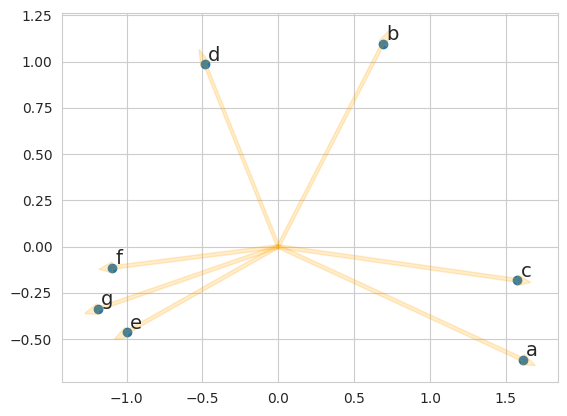

In [36]:
fig, ax = plt.subplots()
ax.scatter(low_dim[:,0], low_dim[:,1])

for i, txt in enumerate(vocab):
    plt.arrow(0, 0, low_dim[i,0], low_dim[i,1], color='orange', width=0.02, alpha=0.2)
    ax.annotate(txt, (low_dim[i,0]+0.02, low_dim[i,1]+0.02), fontsize=14)

In [42]:
def get_node2vec_embedding(g, p, q, r, l, epochs, hidden_dims, window_size):
    
    # generate random walks with search bias
    g2 = second_order_network(g)
    create_search_bias(g2, g, p=p, q=q)
    rw = pp.processes.HigherOrderRandomWalk(g2, first_order_network=g, weight='edge_weight')
    data = rw.run_experiment(runs=r, steps=l)
    walk_data = rw.get_paths(data)
    walks = []
    for walk in walk_data.paths:
        walks.append(g.mapping.to_ids(walk.node_sequence.squeeze().tolist()))

    # build node-context pairs
    vocab = build_vocabulary(walks)
    pairs = build_word_context_pairs(walks, window_size=window_size)

    # initialize and train model
    model = SkipGram(hidden_dims, len(vocab)).to(device)
    loss_function = torch.nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    losses = []
    for i in range(epochs):
        l = 0
        for center, context in pairs:
            model.zero_grad()
            prob = model.forward(get_ohe(center, vocab))
            loss = loss_function(prob, get_ohe(context, vocab).float())
            loss.backward()
            optimizer.step()        
            l += loss.data.to('cpu')

        losses.append(l/len(pairs))
    plt.plot(range(epochs), losses)
    svd = TruncatedSVD()
    return svd.fit_transform(np.array([ get_embedding(w, model, vocab).detach().cpu().numpy() for w in vocab])), vocab


100%|██████████| 100/100 [00:00<00:00, 1402.33it/s]


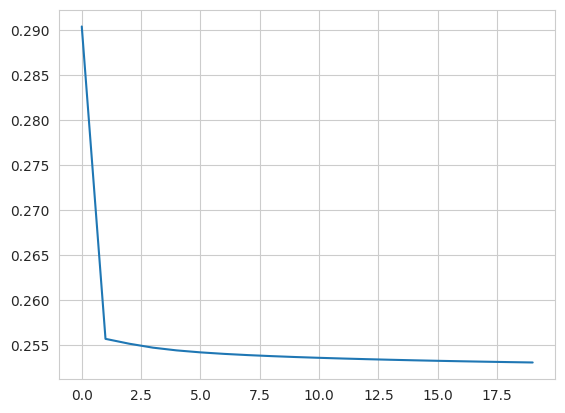

In [43]:
# low return probability, strong exploitation bias
embedding, vocab = get_node2vec_embedding(g, p=100, q=100, r=100, l=10, epochs=20, hidden_dims=5, window_size=2)

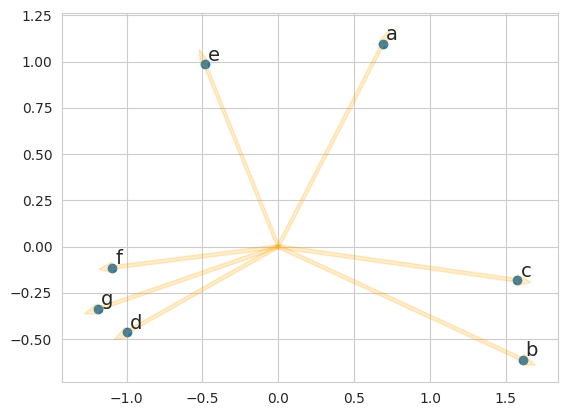

In [44]:
fig, ax = plt.subplots()
ax.scatter(low_dim[:,0], low_dim[:,1])

for i, txt in enumerate(vocab):
    plt.arrow(0, 0, low_dim[i,0], low_dim[i,1], color='orange', width=0.02, alpha=0.2)
    ax.annotate(txt, (low_dim[i,0]+0.02, low_dim[i,1]+0.02), fontsize=14)

In the resulting embedding, we find that node pairs $(b, e)$, $(b,f)$, and $(b,g)$ are placed at opposite ends of the vector space. The reason is that for those node pairs to appear within one window a random walker would need to explore the network, i.e. not walking to one of the nodes that are at distance 1 from the previously visited node.

This changes if we use a value of $q<1$, which introduces a bias towards walks that explore the network, i.e. walks tend to avoid moving to nodes at distance 1 of the previously visited node.

100%|██████████| 100/100 [00:00<00:00, 1378.72it/s]


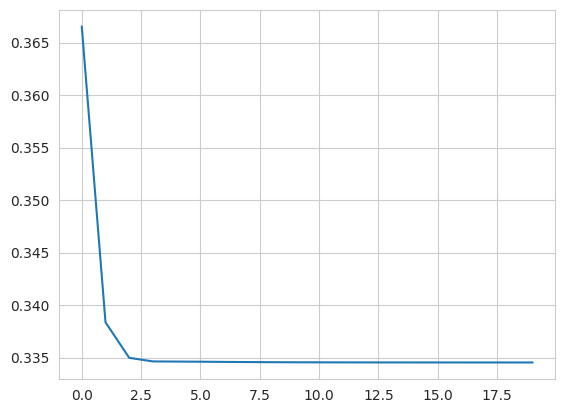

In [45]:
# low return probability, strong exploration bias
embedding, vocab = get_node2vec_embedding(g, p=100, q=0.01, r=100, l=10, epochs=20, hidden_dims=5, window_size=2)

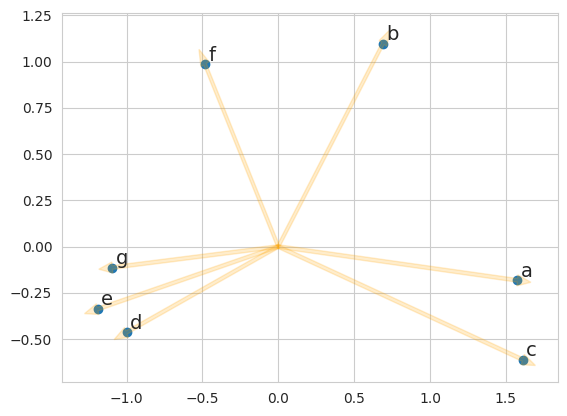

In [46]:
fig, ax = plt.subplots()
ax.scatter(low_dim[:,0], low_dim[:,1])

for i, txt in enumerate(vocab):
    plt.arrow(0, 0, low_dim[i,0], low_dim[i,1], color='orange', width=0.02, alpha=0.2)
    ax.annotate(txt, (low_dim[i,0]+0.02, low_dim[i,1]+0.02), fontsize=14)

We now find that in the resulting embedding, the node pairs $(b,e)$, $(b,f)$ and $(b, g)$ are more similar to each other. Conversely, the nodes within the clusters $\{a, b, c\}$ and $\{d,e,f,g\}$ are less similar because the random walk will avoid sequences that exclusively consist of nodes within those tightly connected clusters.

How does the parameter $p$, which controls the return probability, influence the embeddings. Let's start with a small value of $p$ (high return probability) and a strong exploitation bias (large value of $q$):

100%|██████████| 100/100 [00:00<00:00, 1337.38it/s]


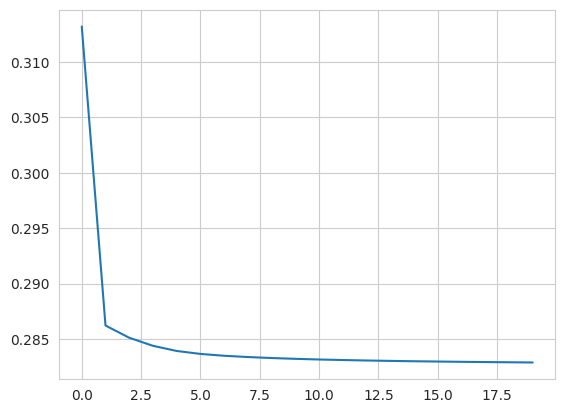

In [47]:
# high return probability, strong exploitation bias
embedding, vocab = get_node2vec_embedding(g, p=0.01, q=100, r=100, l=10, epochs=20, hidden_dims=5, window_size=2)

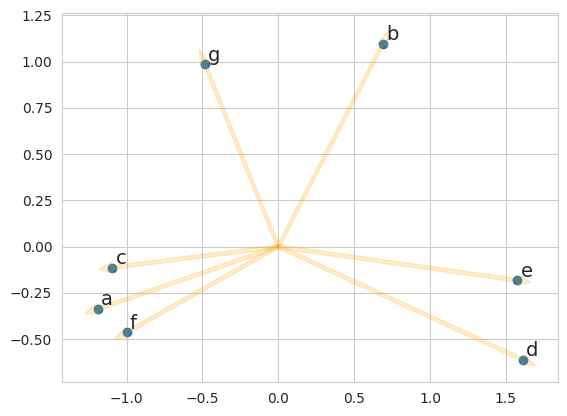

In [48]:
fig, ax = plt.subplots()
ax.scatter(low_dim[:,0], low_dim[:,1])

for i, txt in enumerate(vocab):
    plt.arrow(0, 0, low_dim[i,0], low_dim[i,1], color='orange', width=0.02, alpha=0.2)
    ax.annotate(txt, (low_dim[i,0]+0.02, low_dim[i,1]+0.02), fontsize=14)

100%|██████████| 100/100 [00:00<00:00, 732.51it/s]


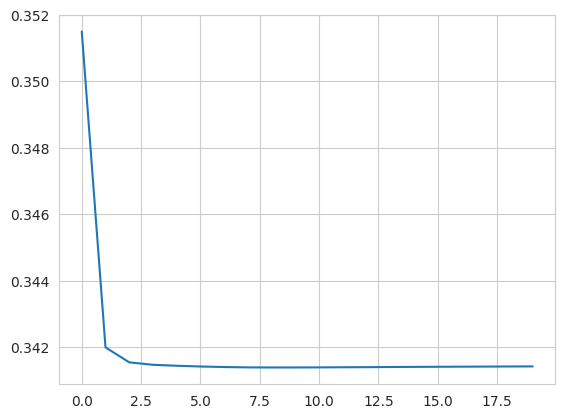

In [49]:
# high return probability, strong exploration bias
embedding, vocab = get_node2vec_embedding(g, p=0.01, q=0.01, r=100, l=20, epochs=20, hidden_dims=5, window_size=2)

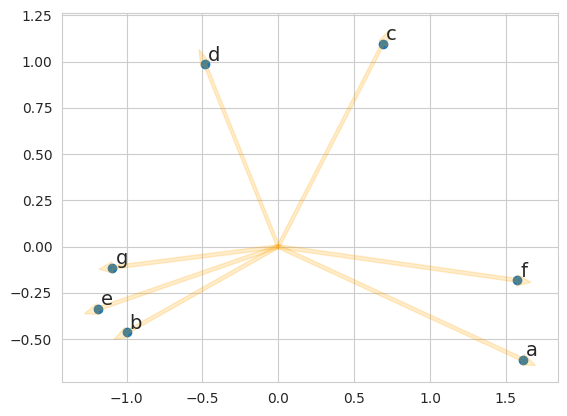

In [50]:
fig, ax = plt.subplots()
ax.scatter(low_dim[:,0], low_dim[:,1])

for i, txt in enumerate(vocab):
    plt.arrow(0, 0, low_dim[i,0], low_dim[i,1], color='orange', width=0.02, alpha=0.2)
    ax.annotate(txt, (low_dim[i,0]+0.02, low_dim[i,1]+0.02), fontsize=14)

## Application to empirical network

In [51]:
karate = pp.io.read_netzschleuder_network('karate', '77')
karate.mapping = pp.IndexMap([str(i) for i in range(karate.N)])

pp.plot(karate)

In [52]:
colors = {}
for v in karate.nodes:
    if karate.data.node_groups[karate.mapping.to_idx(v)][0] == 1:
        colors[v] = 'orange'
    else:
        colors[v] = 'blue'

100%|██████████| 100/100 [00:02<00:00, 47.06it/s]


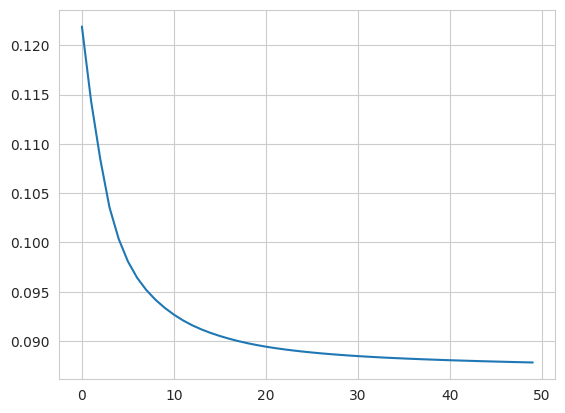

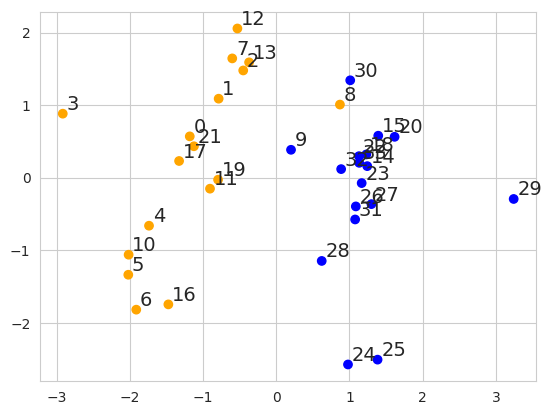

In [53]:
# low return probability, strong exploitation bias
embedding, vocab = get_node2vec_embedding(karate, p=100, q=20, r=100, l=20, epochs=50, hidden_dims=5, window_size=2)
fig, ax = plt.subplots()
ax.scatter(embedding[:,0], embedding[:,1], c=[colors[v] for v in vocab])

for i, txt in enumerate(vocab):
    ax.annotate(txt, (embedding[i,0]+0.05, embedding[i,1]+0.05), fontsize=14)

100%|██████████| 100/100 [00:02<00:00, 46.76it/s]


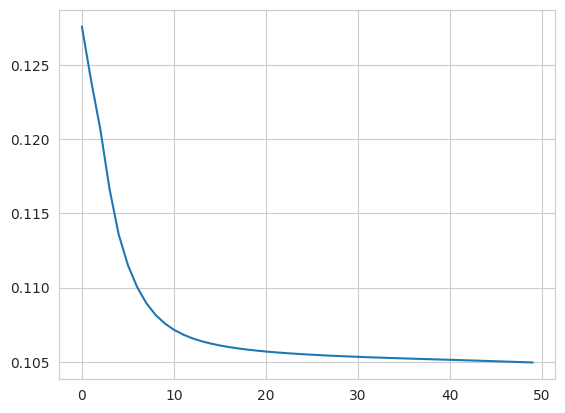

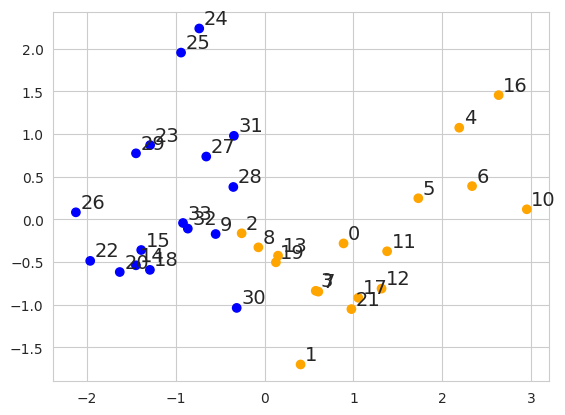

In [54]:
# low return probability, strong exploration bias
embedding, vocab = get_node2vec_embedding(karate, p=100, q=0.1, r=100, l=20, epochs=50, hidden_dims=5, window_size=2)
fig, ax = plt.subplots()
ax.scatter(embedding[:,0], embedding[:,1], c=[colors[v] for v in vocab])

for i, txt in enumerate(vocab):
    ax.annotate(txt, (embedding[i,0]+0.05, embedding[i,1]+0.05), fontsize=14)

100%|██████████| 100/100 [00:02<00:00, 47.04it/s]


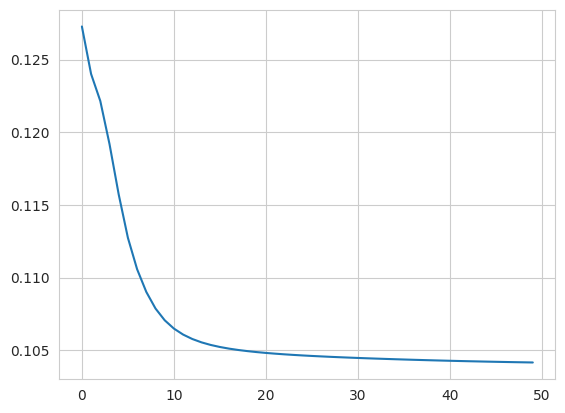

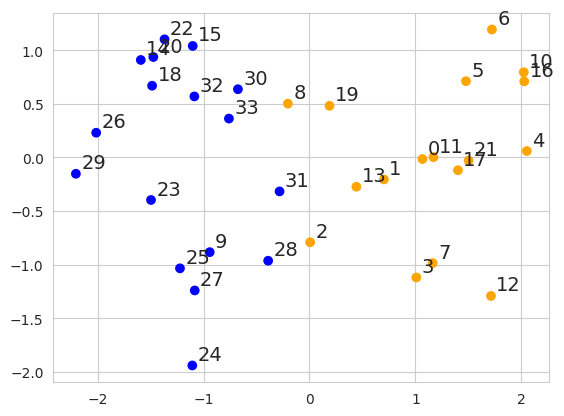

In [55]:
# equivalent to DeepWalk
embedding, vocab = get_node2vec_embedding(karate, p=1, q=1, r=100, l=20, epochs=50, hidden_dims=5, window_size=2)
fig, ax = plt.subplots()
ax.scatter(embedding[:,0], embedding[:,1], c=[colors[v] for v in vocab])

for i, txt in enumerate(vocab):
    ax.annotate(txt, (embedding[i,0]+0.05, embedding[i,1]+0.05), fontsize=14)